In [1]:
# import libraries
import sys
import numpy as np
import cv2
import pywt
from matplotlib import pyplot as plt

In [2]:
def revised_coeff(num):
    h, w = np.shape(num)
    k = 3  # kernal
    image_result = np.zeros((h, w))
    number_new = np.pad(num, [1, 1], mode="constant")

    for i in range(h):
        for j in range(w):
            mat = number_new[i:i + k, j:j + k]
            image_result[i, j] = mat.max()

    return image_result


def consistency_verify(binary):
    h, w = np.shape(binary)
    k = 3
    imag = np.ones((h, w))
    new = np.pad(binary, [1, 1], mode="constant")

    # if 1s are more than 0s , make 1 or else 0
    for i in range(h):
        for j in range(w):
            mat = new[i:i + k, j:j + k]
            if (np.sum(mat) >= 5):
                imag[i][j] = 1
            else:
                imag[i][j] = 0
    # negation
    imag = 1 - imag
    new2 = np.pad(imag, [1, 1], mode="constant")
    final = np.ones((h, w))

    for i in range(h):
        for j in range(w):
            mat = new2[i:i + k, j:j + k]
            if (np.sum(mat) >= 5):
                final[i][j] = 1
            else:
                final[i][j] = 0
    # negation
    final = 1 - final

    return final


# max selection
def max_selection(first, second, mode=1):
    coef_first = revised_coeff(first)
    coef_second = revised_coeff(second)
    h, w = np.shape(coef_first)

    # Binary map
    binary_map = np.zeros((h, w));

    # for max_max
    # Here 0 means first image and 1 means second image
    for i in range(h):
        for j in range(w):
            if abs(coef_first[i][j]) > abs(coef_second[i][j]):
                binary_map[i][j] = 0
            else:
                binary_map[i][j] = 1

    verified_map = consistency_verify(binary_map)

    h, w = np.shape(verified_map)
    for i in range(h):
        for j in range(w):
            if (verified_map[i][j] == 1):  # if 1 use image 2 pixel value else keep same as image 1
                first[i][j] = second[i][j]

    return first


# wavelet function to apply wavelet decomposition
def wavelet(image1, image2, mode=1):
    [cA1, (cH1, cV1, cD1)] = pywt.dwt2(image1, wavelet="coif5",
                                       mode='periodization')  # taking wavelet transform of first image
    [cA2, (cH2, cV2, cD2)] = pywt.dwt2(image2, wavelet="coif5",
                                       mode='periodization')  # wavelet transfrom of second image

    cA = max_selection(cA1, cA2, mode)
    cH = max_selection(cH1, cH2, mode)
    cV = max_selection(cV1, cV2, mode)
    cD = max_selection(cD1, cD2, mode)

    Final = pywt.idwt2([cA, (cH, cV, cD)], wavelet="coif5", mode='periodization')  # inverse wavelet transform
    Final = np.uint8(Final)
    return Final


# Fusion of images
def fuse_images(img1, img2):
    r_fusion = wavelet(img1[:, :, 0], img2[:, :, 0])
    g_fusion = wavelet(img1[:, :, 1], img2[:, :, 1])
    b_fusion = wavelet(img1[:, :, 2], img2[:, :, 2])

    fused = np.uint8(np.dstack([r_fusion, g_fusion, b_fusion]))

    return fused

In [3]:
img1_name = '/content/dog.jpg'
img2_name = '/content/Sample_cat_image.jpeg'

In [4]:
img1 = cv2.imread(img1_name)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

img2 = cv2.imread(img2_name)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

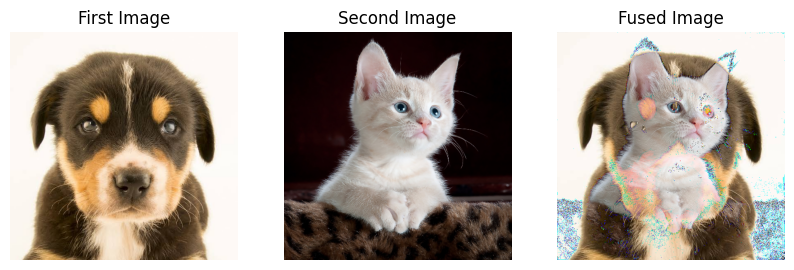

*****Images Fused!!!******
*****Result Displayed****


In [5]:
rows, columns = np.shape(img1[:, :, 1])
if (np.shape(img1) != np.shape(img2)):
    img2 = cv2.resize(img2, (rows, columns))

Fused = fuse_images(img1, img2)

fig = plt.figure(figsize=(10,7))

fig.add_subplot(1,3, 1)
plt.imshow(img1)
plt.axis('off')
plt.title("First Image")

fig.add_subplot(1,3, 2)
plt.imshow(img2)
plt.axis('off')
plt.title("Second Image")

fig.add_subplot(1,3,3 )
plt.imshow(Fused)
plt.axis('off')
plt.title("Fused Image")

plt.show()

print("*****Images Fused!!!******")
print("*****Result Displayed****")

